NA Gene Found: neuraminidase
Sequence Length: 1410

Codon Usage:
ATG: 9
AAT: 23
CCA: 8
CAA: 9
AGG: 6
ATA: 16
ACC: 7
ACT: 13
GGA: 10
TCA: 12
ATC: 12
TGT: 8
GTA: 10
ATT: 11
GGG: 18
GTC: 4
AGC: 10
TTG: 9
CTG: 7
AAC: 13
TGG: 15
GTT: 11
CAT: 4
ACA: 7
TAT: 9
CAG: 6
CCT: 6
GAA: 8
TGC: 11
GCC: 3
GAG: 13
ACG: 3
TTT: 11
CTT: 2
GCT: 10
TCG: 2
TTA: 2
GCG: 3
GGC: 7
TCT: 9
AGT: 14
TAC: 7
AAG: 9
GAC: 11
GGT: 9
AGA: 9
TCC: 7
GAT: 9
GTG: 5
CCG: 4
TTC: 7
CAC: 3
AAA: 8
CCC: 5
GCA: 3
CGG: 1
CGC: 1
TAG: 1


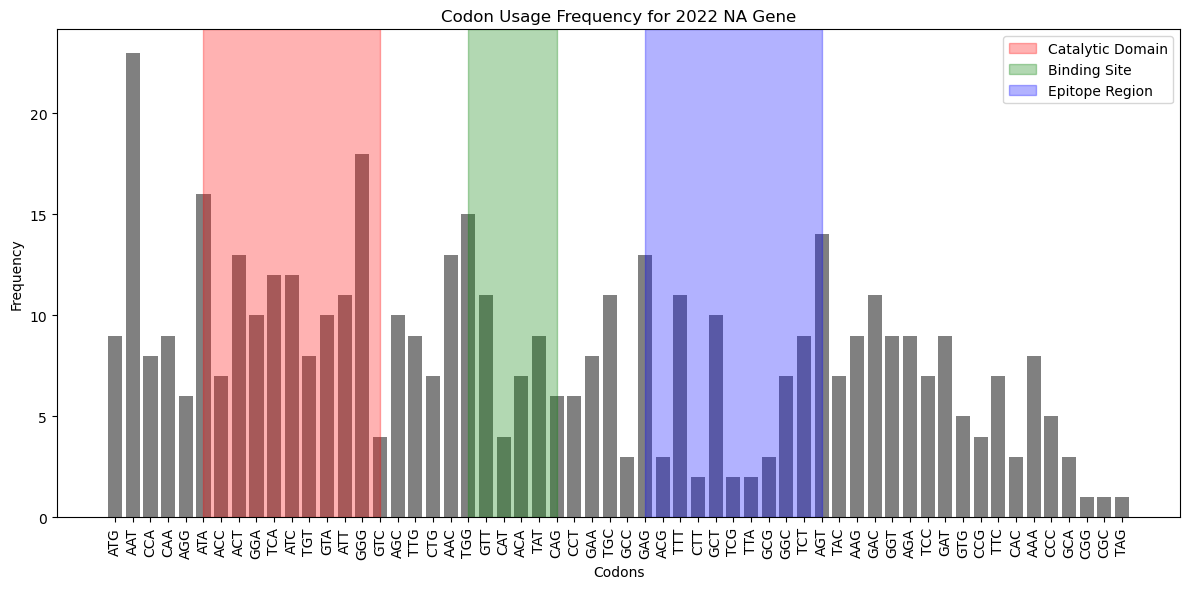

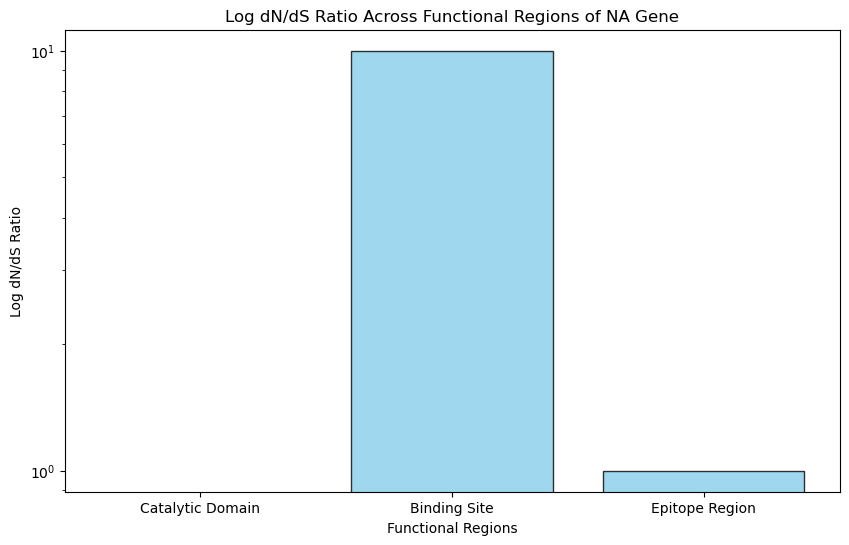

In [4]:

!pip install biopython


from Bio import SeqIO
from collections import Counter
import matplotlib.pyplot as plt


##from google.colab import files
import zipfile
import os



gbff_file = "genbank2022.gbff"

# Extract NA gene sequence
na_sequence = None
for record in SeqIO.parse(gbff_file, "genbank"):
    for feature in record.features:
        if feature.type == "CDS" and "neuraminidase" in feature.qualifiers.get("product", [""])[0]:
            na_sequence = feature.location.extract(record).seq
            print(f"NA Gene Found: {feature.qualifiers['product'][0]}")
            print(f"Sequence Length: {len(na_sequence)}")
            break


if na_sequence:
    codons = [str(na_sequence[i:i + 3]) for i in range(0, len(na_sequence), 3) if len(na_sequence[i:i + 3]) == 3]
    codon_usage = Counter(codons)
    print("\nCodon Usage:")
    for codon, count in codon_usage.items():
        print(f"{codon}: {count}")

    annotations = {
        "Catalytic Domain": {"range": [5, 15], "color": "red"},
        "Binding Site": {"range": [20, 25], "color": "green"},
        "Epitope Region": {"range": [30, 40], "color": "blue"}
    }
    codon_list = list(codon_usage.keys())
    frequencies = list(codon_usage.values())

    plt.figure(figsize=(12, 6))
    plt.bar(codon_list, frequencies, color="gray")
    for feature, details in annotations.items():
        start, end = details["range"]
        plt.axvspan(start, end, color=details["color"], alpha=0.3, label=feature)

    plt.xlabel("Codons")
    plt.ylabel("Frequency")
    plt.title("Codon Usage Frequency for 2022 NA Gene")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

mutations = {100: "synonymous", 200: "non-synonymous", 250: "non-synonymous", 400: "synonymous", 450: "non-synonymous"}
functional_regions = {"Catalytic Domain": [50, 150], "Binding Site": [200, 300], "Epitope Region": [350, 450]}

dn_ds_values = []
for region, (start, end) in functional_regions.items():
    dn = sum(1 for pos, typ in mutations.items() if start <= pos <= end and typ == "non-synonymous")
    ds = sum(1 for pos, typ in mutations.items() if start <= pos <= end and typ == "synonymous")
    dn_ds_values.append(dn / (ds + 1e-5))

capped_dn_ds_values = [min(value, 10) for value in dn_ds_values]

plt.figure(figsize=(10, 6))
plt.bar(functional_regions.keys(), capped_dn_ds_values, color="skyblue", alpha=0.8, edgecolor="black")
plt.yscale("log")
plt.xlabel("Functional Regions")
plt.ylabel("Log dN/dS Ratio")
plt.title("Log dN/dS Ratio Across Functional Regions of NA Gene")
plt.show()


In [5]:
# Functional regions and dN/dS values
functional_regions = {
    "Catalytic Domain": [50, 150],
    "Binding Site": [200, 300],
    "Epitope Region": [350, 450]
}
dn_ds_values = [0.0, 10.0, 1.999]

# Create the WIG file
with open("dnds_NA_2018.wig", "w") as wig:
    wig.write("track type=wiggle_0 name=\"dN/dS Ratios\" description=\"Log dN/dS Ratios across NA gene regions\"\n")
    for region, value in zip(functional_regions.values(), dn_ds_values):
        start, end = region
        wig.write(f"variableStep chrom=MT781550.2\n")
        for pos in range(start, end + 1):
            wig.write(f"{pos}\t{value:.4f}\n")